In [1]:
%matplotlib inline
from setting.matplotlib_ import *
from setting.tools import *

In [2]:
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
PCSE version: 5.5.0


거의 모든 과정이 동일합니다. <br>
목표만 하나 추가해주면 됩니다.

## Loading environment data

In [3]:
target_env = pd.read_csv('./data/pap_env_RDA_open.csv', skiprows=1, header=None)
target_env.loc[:, 0] = pd.DatetimeIndex(target_env.loc[:, 0])
template = pd.read_excel('./data/data_template.xls', header=None)

In [4]:
target_env = pd.concat([template.loc[:11], target_env], axis=0)

In [5]:
target_env.to_excel('./data/pap_env_processed.xls', index=False, header=False)

/tmp/ipykernel_308057/2866564418.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  target_env.to_excel('./data/pap_env_processed.xls', index=False, header=False)


## Loading growth data

In [6]:
target_output = pd.read_csv(f'./data/pap_grw_RDA_open.csv', index_col='date')
target_output['LAI'] = (target_output['lefCunt']*target_output['lefLt']*target_output['lefBt'])/1000
target_output.index = pd.DatetimeIndex(target_output.index)

In [7]:
target_output.loc[target_output['LAI'] == 0, 'LAI'] = np.nan
target_output.loc[:, 'LAI'] = target_output.loc[:, 'LAI'].ffill()
target_output = target_output.loc[~target_output.loc[:, 'LAI'].isna()]

In [8]:
target_output = target_output.loc[:, ['LAI', 'cum_harvest']]
target_output.columns = ['LAI', 'TWSO']

<AxesSubplot:xlabel='date'>

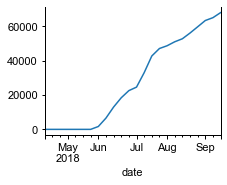

In [9]:
target_output.TWSO.plot()

In [10]:
FACTOR = 0.075
target_output.loc[:, 'TWSO'] *= FACTOR

수확량에 대한 지표로 TWSO를 선택해서 목표로 삼습니다. <br>
그러나, 시뮬레이션에 사용되는 값은 생체중이 아닌 건물중이므로 값을 조정하겠습니다.

<AxesSubplot:xlabel='date'>

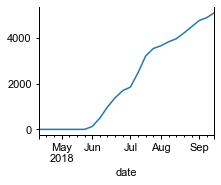

In [11]:
target_output.TWSO.plot()

In [12]:
minmax = pd.concat([target_output.min(), target_output.max()], axis=1)
minmax.columns = ['min', 'max']

두 지표의 범위가 다르므로, loss에 같은 정도로 반영될 수 있도록 범위를 맞춰줄 필요가 있습니다. <br>
`minmax`가 존재하면 `ObjectiveFunctionCalculator`가 목표 지표들의 범위를 0-1로 normalize합니다.

In [13]:
CROP_NAME = 'soybean'
VARIETY_NAME = 'Soybean_906'
START_DATE = str(pd.Timestamp('2018-03-23').date()) # starting date was deleted because of dropna
END_DATE = str(target_output.index[-1].date())
CULT_PERIOD = (pd.Timestamp(END_DATE)- pd.Timestamp(START_DATE)).days
print(f'from {START_DATE} to {END_DATE}: {CULT_PERIOD} days')

from 2018-03-23 to 2018-09-21: 182 days


## Input data for WOFOST

In [14]:
cropd = YAMLCropDataProvider()
soild = DummySoilDataProvider()
sited = WOFOST72SiteDataProvider(WAV=50, CO2=360.)
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [15]:
# Agromanagement for the custom data
agro_yaml = f"""
- {START_DATE}:
    CropCalendar:
        crop_name: {CROP_NAME}
        variety_name: {VARIETY_NAME}
        crop_start_date: {START_DATE}
        crop_start_type: emergence
        crop_end_date: {END_DATE}
        max_duration: {CULT_PERIOD}
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml, Loader=yaml.FullLoader)

In [16]:
wdp = ExcelWeatherDataProvider('./data/pap_env_processed.xls')

## WOFOST Initialization

In [17]:
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()

## Parameter selection

In [18]:
target_params = {'TDWI':[0, 2000], 'TBASE':[0, 30], 'TSUM1':[0, 1000],'TSUM2':[1000, 4000],
                 'RGRLAI':[0, 0.01], 'SPAN':[0, 500], 'PERDL':[0, 1],
                 'SLATB':[0.001, 0.005, 3, [0, 2]], 'FRTB':[0, 1, 3, [0, 2]], 'AMAXTB':[0, 50, 3, [0, 2]]}
target_obj = target_output.columns

In [19]:
origin_value = {}
for k in target_params:
    v = params._cropdata[k]
    origin_value[k] = v

## HyperOpt preparation

In [20]:
space = {}
for k in [_ for _ in target_params if not _.endswith('TB')]:
    space[k] = hp.uniform(k, target_params[k][0], target_params[k][1])
for k in [_ for _ in target_params if _.endswith('TB')]:
    for i in range(target_params[k][2]):
        space[f'{k}_{i}'] = hp.uniform(f'{k}_{i}', target_params[k][0], target_params[k][1])

## Optimization process

In [21]:
objfunc_calculator = ObjectiveFunctionCalculator(target_params, target_obj, params, wdp, agro, target_output, minmax)

In [22]:
best = fmin(fn=objfunc_calculator, space=space, algo=tpe.suggest, max_evals=50)

100%|████████| 50/50 [00:12<00:00,  3.95trial/s, best loss: 0.03724619014177633]


## Result

In [23]:
print('<Calibration result>')
for k in target_params:
    if not k.endswith('TB'):
        print(f'{k}: {origin_value[k]} -> {best[k]:.2f}')
    else:
        temp_list = []
        for v1, v2 in zip(np.linspace(target_params[k][-1][0], target_params[k][-1][1], target_params[k][2]),
                          [_ for _ in best if _.startswith(k)]):
            temp_list.append(v1)
            temp_list.append(best[v2])
        print(f'{k}: {origin_value[k]} -> {[np.round(_, 4) for _ in temp_list]}')

<Calibration result>
TDWI: 120.0 -> 1672.24
TBASE: 7.0 -> 10.89
TSUM1: 500 -> 513.66
TSUM2: 1300 -> 2166.34
RGRLAI: 0.007 -> 0.01
SPAN: 23.0 -> 426.96
PERDL: 0.03 -> 0.46
SLATB: [0.0, 0.0014, 0.45, 0.0025, 0.9, 0.0025, 2.0, 0.0007] -> [0.0, 0.001, 1.0, 0.0034, 2.0, 0.0036]
FRTB: [0.0, 0.65, 0.75, 0.45, 1.0, 0.2, 1.5, 0.0, 2.0, 0.0] -> [0.0, 0.2555, 1.0, 0.8865, 2.0, 0.3752]
AMAXTB: [0.0, 29.0, 1.7, 29.0, 2.0, 0.0] -> [0.0, 19.7906, 1.0, 25.3793, 2.0, 36.4381]


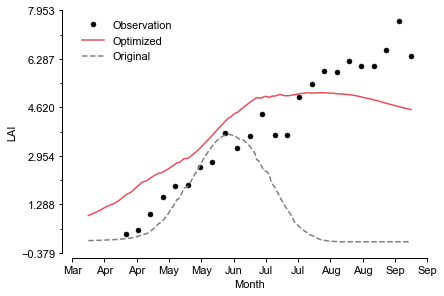

In [24]:
fig = plt.figure(figsize=((8/2.54*2), (6/2.54*1.8)))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

ax.plot(target_output.index, target_output.LAI, 'o', ms=5, mew=0.5, mec='k', c='k', label="Observation")
_ = objfunc_calculator(best)
ax.plot(objfunc_calculator.sim.index, objfunc_calculator.sim.LAI, c=cmap[0], label="Optimized")
_ = objfunc_calculator(origin_value, is_train=False)
ax.plot(objfunc_calculator.sim.index, objfunc_calculator.sim.LAI, "--", c='gray', label="Original")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(LinearLocator(12))
ax.yaxis.set_major_locator(LinearLocator(6))
ax.yaxis.set_minor_locator(LinearLocator(11))
ax.set_xlabel('Month')
ax.set_ylabel('LAI')

ax.legend(frameon=False, loc=0)
fig.tight_layout()
plt.show()

In [25]:
compare_df = pd.read_csv(f'./data/pap_grw_RDA_open.csv', index_col='date')
compare_df.index = pd.DatetimeIndex(compare_df.index)

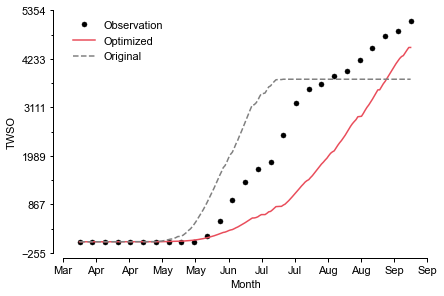

In [26]:
# rerun with the best parameters found
fig = plt.figure(figsize=((8/2.54*2), (6/2.54*1.8)))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

ax.plot(compare_df.index, compare_df.cum_harvest*FACTOR, 'o', ms=5, mew=0.5, mec='k', c='k', label="Observation")
_ = objfunc_calculator(best)
ax.plot(objfunc_calculator.sim.index, objfunc_calculator.sim.TWSO, c=cmap[0], label="Optimized")
_ = objfunc_calculator(origin_value, is_train=False)
ax.plot(objfunc_calculator.sim.index, objfunc_calculator.sim.TWSO, "--", c='gray', label="Original")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(LinearLocator(12))
ax.yaxis.set_major_locator(LinearLocator(6))
ax.yaxis.set_minor_locator(LinearLocator(11))
ax.set_xlabel('Month')
ax.set_ylabel('TWSO')

ax.legend(frameon=False, loc=0)
fig.tight_layout()
plt.show()

간단하게 한 항목 추가하는 것으로 TWSO에 대해서도 최적화할 수 있습니다.